# 015. word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import re

### Toy 말뭉치

In [2]:
# corpus = ['king is a very strong man',
#           'queen is a wise and pretty woman',
#           'boy is a young man',
#           'girl is a young and pretty woman',
#           'prince is young and will be a strong and wise king',
#           'princess is a young woman and will be a pretty and wise queen',
#           'man is strong',
#           'woman is pretty',
#           'prince is a boy will be a king',
#           'princess is a girl will be a queen']

corpus = ['왕은 매우 강한 남자이다',
          '여왕은 현명한 예쁜 여자이다',
          '소년은 젊은 남자이다',
          '소녀는 젊은 예쁜 여자이다',
          '왕자는 젊고 현명한 왕이 될 것이다',
          '공주는 젊고 예쁜 현명한 여왕이 될 것이다',
          '남자는 강하다',
          '여자는 예쁘다',
          '왕자는 왕이 될 소년이다',
          '공주는 왕비가 될 소녀이다']

In [3]:
cleaned_corpus = []
for text in corpus:
    print(text)
    # text = re.sub(r'[^a-zA-Z]', '', text)  #영문
    text = re.sub(r'[^a가-힣]', '', text)  #한글
    cleaned_corpus.append(text.lower())

왕은 매우 강한 남자이다
여왕은 현명한 예쁜 여자이다
소년은 젊은 남자이다
소녀는 젊은 예쁜 여자이다
왕자는 젊고 현명한 왕이 될 것이다
공주는 젊고 예쁜 현명한 여왕이 될 것이다
남자는 강하다
여자는 예쁘다
왕자는 왕이 될 소년이다
공주는 왕비가 될 소녀이다


### stopword 제거

In [ ]:
# Install konlpy
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [4]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs

<bound method Okt.morphs of <konlpy.tag._okt.Okt object at 0x7fed93417c70>>

In [6]:
# stop_words = ['is', 'a' ,'will', 'be', 'and']
stop_words = ['은', '가', '이다', '는', '이', '될']

results = []

for text in corpus:
    tmp = []
    for word in okt.morphs(text):
    # for word in text.split():
        if word not in stop_words:
            tmp.append(word)
    results.append(' '.join(tmp))

In [7]:
cleaned_corpus = results
cleaned_corpus

['왕 매우 강한 남자',
 '여왕 현명한 예쁜 여자',
 '소년 젊은 남자',
 '소녀 젊은 예쁜 여자',
 '왕자 젊고 현명한 왕 것',
 '공주 젊고 예쁜 현명한 여왕 것',
 '남자 강하다',
 '여자 예쁘다',
 '왕자 왕 소년',
 '공주 왕비 소녀']

### vocaburary 모음 작성

In [8]:
words = []

for sentence in corpus:
    for word in sentence.split(' '):
        words.append(word)

words = list(set(words))
words

['소녀는',
 '여왕은',
 '예쁘다',
 '될',
 '남자는',
 '왕이',
 '것이다',
 '예쁜',
 '왕비가',
 '소녀이다',
 '젊고',
 '현명한',
 '왕자는',
 '남자이다',
 '매우',
 '공주는',
 '소년은',
 '여자는',
 '여왕이',
 '강하다',
 '소년이다',
 '강한',
 '여자이다',
 '젊은',
 '왕은']

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [9]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [10]:
word2index

{'소녀는': 0,
 '여왕은': 1,
 '예쁘다': 2,
 '될': 3,
 '남자는': 4,
 '왕이': 5,
 '것이다': 6,
 '예쁜': 7,
 '왕비가': 8,
 '소녀이다': 9,
 '젊고': 10,
 '현명한': 11,
 '왕자는': 12,
 '남자이다': 13,
 '매우': 14,
 '공주는': 15,
 '소년은': 16,
 '여자는': 17,
 '여왕이': 18,
 '강하다': 19,
 '소년이다': 20,
 '강한': 21,
 '여자이다': 22,
 '젊은': 23,
 '왕은': 24}

### skip-gram 으로 training data 생성

In [11]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences

[['왕은', '매우', '강한', '남자이다'],
 ['여왕은', '현명한', '예쁜', '여자이다'],
 ['소년은', '젊은', '남자이다'],
 ['소녀는', '젊은', '예쁜', '여자이다'],
 ['왕자는', '젊고', '현명한', '왕이', '될', '것이다'],
 ['공주는', '젊고', '예쁜', '현명한', '여왕이', '될', '것이다'],
 ['남자는', '강하다'],
 ['여자는', '예쁘다'],
 ['왕자는', '왕이', '될', '소년이다'],
 ['공주는', '왕비가', '될', '소녀이다']]

In [12]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [13]:
data[:10]

[['왕은', '매우'],
 ['왕은', '강한'],
 ['매우', '왕은'],
 ['매우', '강한'],
 ['매우', '남자이다'],
 ['강한', '왕은'],
 ['강한', '매우'],
 ['강한', '남자이다'],
 ['남자이다', '매우'],
 ['남자이다', '강한']]

In [14]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,왕은,매우
1,왕은,강한
2,매우,왕은
3,매우,강한
4,매우,남자이다


### One hot encoding

In [15]:
from tensorflow.keras.utils import to_categorical

len(words)

25

### One hot encoding 된 train, label data

In [16]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [17]:
print(X[:3])
print(Y[:3])

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]


In [18]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [19]:
model = Sequential()
model.add(Dense(2, input_dim=len(words)))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit(X_train, Y_train, epochs=500, batch_size=3)

Epoch 1/500
34/34 [==============================] - 1s 2ms/step - loss: 7.3397 - accuracy: 0.0300
Epoch 2/500
34/34 [==============================] - 0s 2ms/step - loss: 8.4150 - accuracy: 0.0300
Epoch 3/500
34/34 [==============================] - 0s 2ms/step - loss: 8.0595 - accuracy: 0.0300
Epoch 4/500
34/34 [==============================] - 0s 2ms/step - loss: 6.4472 - accuracy: 0.0300
Epoch 5/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 6/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 7/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 8/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 9/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 10/500
34/34 [==============================] - 0s 2ms/step - loss: 5.8025 - accuracy: 0.0300
Epoch 11/

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 52        
                                                                 
 dense_1 (Dense)             (None, 25)                75        
                                                                 
Total params: 127 (508.00 Byte)
Trainable params: 127 (508.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.layers[0].get_weights()

[array([[ 0.07727858,  0.00251166],
        [-0.19817773,  0.43543547],
        [ 0.17483485,  0.09195789],
        [-0.4678006 , -0.34881842],
        [-0.15887216,  0.26294878],
        [ 0.29333958,  0.14842603],
        [ 0.00744572,  0.23145935],
        [ 0.06447819,  0.4679096 ],
        [-0.13961002, -0.46740955],
        [ 0.18719482,  0.4171239 ],
        [ 0.13874564, -0.1497179 ],
        [ 0.41600522,  0.16869685],
        [ 0.3034219 , -0.1436943 ],
        [ 0.31472793,  0.0985591 ],
        [ 0.31318662, -0.13155907],
        [ 0.41524607, -0.32472646],
        [-0.28107104,  0.1358523 ],
        [ 0.23718628, -0.06044734],
        [ 0.11594468, -0.02737098],
        [ 0.23639902,  0.11592098],
        [-0.21247879, -0.35063863],
        [-0.30197588,  0.10152987],
        [-0.40032429,  0.06178559],
        [ 0.16109146, -0.43875736],
        [ 0.4378105 , -0.12907268]], dtype=float32),
 array([ 0.00050646, -0.00564933], dtype=float32)]

In [23]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[ 0.07778504, -0.00313768],
       [-0.19767126,  0.42978615],
       [ 0.17534131,  0.08630855],
       [-0.46729413, -0.35446775],
       [-0.1583657 ,  0.25729945]], dtype=float32)

In [24]:
words

['소녀는',
 '여왕은',
 '예쁘다',
 '될',
 '남자는',
 '왕이',
 '것이다',
 '예쁜',
 '왕비가',
 '소녀이다',
 '젊고',
 '현명한',
 '왕자는',
 '남자이다',
 '매우',
 '공주는',
 '소년은',
 '여자는',
 '여왕이',
 '강하다',
 '소년이다',
 '강한',
 '여자이다',
 '젊은',
 '왕은']

In [25]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = words
w2v

,x1,x2,word
0,0.077785,-0.003138,소녀는
1,-0.197671,0.429786,여왕은
2,0.175341,0.086309,예쁘다
3,-0.467294,-0.354468,될
4,-0.158366,0.257299,남자는
5,0.293846,0.142777,왕이
6,0.007952,0.225810,것이다
7,0.064985,0.462260,예쁜
8,-0.139104,-0.473059,왕비가
9,0.187701,0.411475,소녀이다


In [32]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,163 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and dire

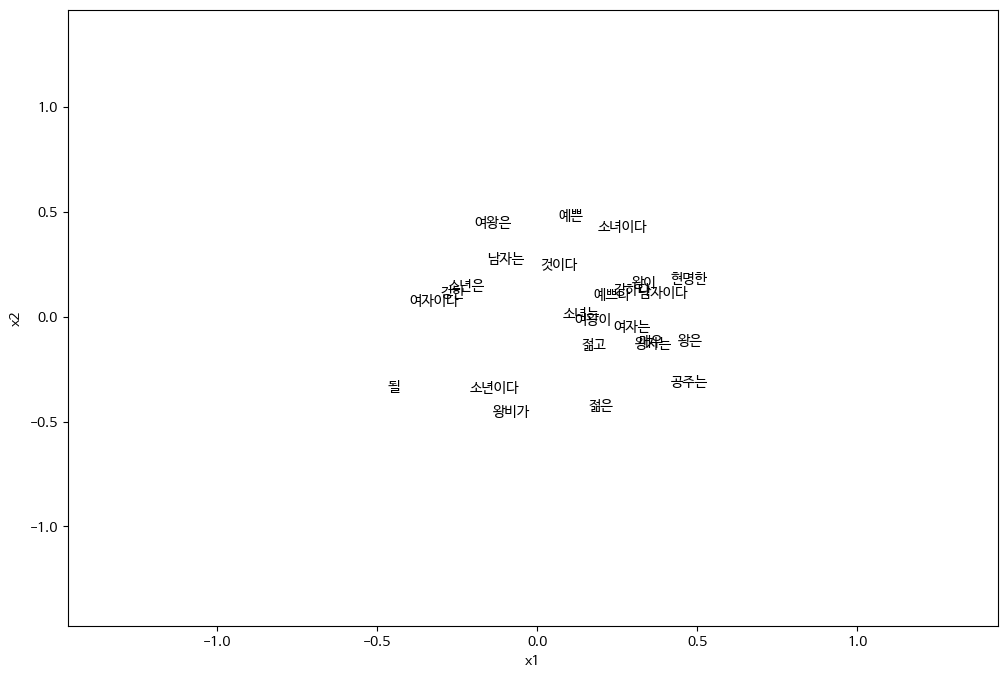

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
#한글 폰트 사용
# from matplotlib import font_manager
# import matplotlib
# font_path = "C:/Windows/Fonts/H2GTRM.TTF"                       #폰트 경로
# font_name = font_manager.FontProperties(fname=font_path).get_name()  #폰트 이름 얻어오기
# matplotlib.rc('font', family=font_name)                                 #font 지정
# matplotlib.rcParams['axes.unicode_minus'] = False               #한글사용시 마이너스 사인 깨짐 방지
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False               #한글사용시 마이너스 사인 깨짐 방지


fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()